Phase 2: Fit model with nonautonomous growth rate functions to data from early experimental time points.

The nondimensional equations are 
$$\begin{align*}
    \frac{dc_m}{d\tau}&=\gamma_m'(y_m)c_m-\delta'(c_m, y_a, y_m)c_m\\
    \frac{dy_a}{d\tau}&=\beta_ac_m-\eta_a\gamma_a'(y_a)(1-c_m)-\delta'(c_m, y_a, y_m)(y_a-\alpha)\\
    \frac{dy_m}{d\tau}&=\beta_m(1-c_m)-\eta_m\gamma_m'(y_m)c_m-\delta'(c_m, y_a, y_m)(y_m-\mu)
\end{align*}$$
where
$\gamma_i'(y_i)=ge^{-a\tau}+\gamma_i(y_i)(1-e^{-a\tau})$ and $\delta'(c_m, y_a, y_m)=\gamma_a'(y_a)(1-c_m)+\gamma_m'(y_m)c_m$.
We scaled the cell equations by $C$ and $\gamma_{a,max}$, and the metabolite equations by $K_m$ and $\gamma_{a,max}$ to nondimensionalize.
The nondimensional parameters are
$$\begin{align*}
\gamma&=\frac{\gamma_{m,max}}{\gamma_{a,max}}\\
K&=\frac{K_a}{K_m}\\
b_{a,m}& \text{ unchanged}\\
\beta'_{a,m}&=\frac{\beta_{a,m}C}{\gamma_{a,max}K_m}\\
\eta'_{a,m}&=\frac{\eta_{a,m}C}{K_m}\\
g&\\
a&
\end{align*}$$
We fix the first 8 parameters to the mean of the posterior from phase 1, and fit parameters $g$ and $a$ in phase 2 here.

In [1]:
import numpy as np
from scipy.integrate import odeint #For ODE integration
import matplotlib.pyplot as plt #For plotting
import pymc as pm
from pymc.ode import DifferentialEquation
import arviz as az

In [2]:
# Set parameter for nondimensionalizing time and concentration later on
gammaamax=2.3
km=.006


Load experimental data from excel file:

In [3]:
import pandas as pd
file_name =  '/Users/amanda/Documents/MATLAB/auxotroph_ratio_control_summary.xlsx' # path to file + file name

#Define function that loads data from each experiment and returns a vector of t values and a vector of r values
def loadData(sheet1, sheet2, sheet3):
    
    df1 = pd.read_excel(io=file_name, sheet_name=sheet1)
    df2 = pd.read_excel(io=file_name, sheet_name=sheet2)
    df3 = pd.read_excel(io=file_name, sheet_name=sheet3)

    combined_df = pd.concat([df1,df2,df3], ignore_index=True)

    combined_df_sorted = combined_df.sort_values(by='Time')

    data=combined_df_sorted.to_numpy()
    lb_avg=(data[:,1]+data[:,2]+data[:,3])/3
    m_avg=(data[:,4]+data[:,5]+data[:,6])/3
    rdata=m_avg/lb_avg
    # Replace entries greater than 1 with 1
    rdata[rdata > 1] = 1
    
    #rescale time by \gamma_{a,max}
    tdata = data[:,0]/60/60*gammaamax

    return tdata, rdata


In [ ]:
tdata_unsupp50,rdata_unsupp50=loadData('metAargC-1','metAargC-2','metAargC-3')
tdata_unsupp99,rdata_unsupp99=loadData('metAargC-99-1-1','metAargC-99-1-2','metAargC-99-1-3')
tdata_unsupp1,rdata_unsupp1=loadData('metAargC-1-99-1','metAargC-1-99-2','metAargC-1-99-3')
tdata1_1,rdata1_1=loadData('metAargC-1uMargmet-1','metAargC-1uMargmet-2','metAargC-1uMargmet-3')
tdata10_10,rdata10_10=loadData('metAargC-10uMarg-10nMmet-1','metAargC-10uMarg-10nMmet-2','metAargC-10uMarg-10nMmet-3')
tdata10_5,rdata10_5=loadData('metAargC-10uMarg-5nMmet-1','metAargC-10uMarg-5nMmet-2','metAargC-10uMarg-5nMmet-3')

# Use only data from times less than \tau = 40
early=40
f_tdata_unsupp99=tdata_unsupp99[tdata_unsupp99 < early]
f_rdata_unsupp99=rdata_unsupp99[:-(len(tdata_unsupp99)-len(f_tdata_unsupp99))]

f_tdata_unsupp50=tdata_unsupp50[tdata_unsupp50 < early]
f_rdata_unsupp50=rdata_unsupp50[:-(len(tdata_unsupp50)-len(f_tdata_unsupp50))]

f_tdata_unsupp1=tdata_unsupp1[tdata_unsupp1 < early]
f_rdata_unsupp1=rdata_unsupp1[:-(len(tdata_unsupp1)-len(f_tdata_unsupp1))]

f_tdata1_1=tdata1_1[tdata1_1 < early]
f_rdata1_1=rdata1_1[:-(len(tdata1_1)-len(f_tdata1_1))]

f_tdata10_10=tdata10_10[tdata10_10 < early]
f_rdata10_10=rdata10_10[:-(len(tdata10_10)-len(f_tdata10_10))]

f_tdata10_5=tdata10_5[tdata10_5 < early]
f_rdata10_5=rdata10_5[:-(len(tdata10_5)-len(f_tdata10_5))]




Define ODE models to use in PyMC

In [5]:
#Define the nonautonomous ODE system in the following function

def nonAutAuxRatio_unsupp(x, t, p):
    #Unpack state variables
    
    cm=x[0]
    ya=x[1]
    ym=x[2]
    
    #Unpack unknown params
    baprime=73.6
    bmprime=1.29
    etaaprime=.118
    etamprime=.048
    gamma=1.014
    K=130.5
    ba=9.04
    bm=5.85
    g=p[0]
    a=p[1]
    
    #Define known params
    alpha=0/km #no supplemented Arg
    m=0/km
    ## Model
    dcmdt=(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm-(((g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba)))*(1-cm)+(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm))*cm
    dyadt = baprime * cm - etaaprime * (g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba))) *(1-cm) -(((g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba)))*(1-cm)+(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm))* (ya-alpha)
    dymdt = bmprime * (1-cm) - etamprime * (g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm))) * cm -(((g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba)))*(1-cm)+(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm))* (ym-m)

    return dcmdt,dyadt,dymdt



def nonAutAuxRatio1_1(x, t, p):
    #Unpack state variables
    
    cm=x[0]
    ya=x[1]
    ym=x[2]
    #Unpack unknown params
    baprime=73.6
    bmprime=1.29
    etaaprime=.118
    etamprime=.048
    gamma=1.014
    K=130.5
    ba=9.04
    bm=5.85
    g=p[0]
    a=p[1]
    
    #Define known params
    alpha=1/km #1\mu M supplemented Arg
    m=1/km
    ## Model
    dcmdt=(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm-(((g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba)))*(1-cm)+(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm))*cm
    dyadt = baprime * cm - etaaprime * (g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba))) *(1-cm) -(((g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba)))*(1-cm)+(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm))* (ya-alpha)
    dymdt = bmprime * (1-cm) - etamprime * (g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm))) * cm -(((g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba)))*(1-cm)+(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm))* (ym-m)

    
    return dcmdt,dyadt,dymdt

def nonAutAuxRatio10_10(x, t, p):
    #Unpack state variables
    
    cm=x[0]
    ya=x[1]
    ym=x[2]
    #Unpack unknown params
    baprime=73.6
    bmprime=1.29
    etaaprime=.118
    etamprime=.048
    gamma=1.014
    K=130.5
    ba=9.04
    bm=5.85
    g=p[0]
    a=p[1]
    
    alpha=10/km 
    m=0.01/km
    
    ## Model
    dcmdt=(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm-(((g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba)))*(1-cm)+(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm))*cm
    dyadt = baprime * cm - etaaprime * (g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba))) *(1-cm) -(((g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba)))*(1-cm)+(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm))* (ya-alpha)
    dymdt = bmprime * (1-cm) - etamprime * (g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm))) * cm -(((g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba)))*(1-cm)+(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm))* (ym-m)

    
    return dcmdt,dyadt,dymdt

def nonAutAuxRatio10_5(x, t, p):
    #Unpack state variables
    
    cm=x[0]
    ya=x[1]
    ym=x[2]
    #Unpack unknown params
    baprime=73.6
    bmprime=1.29
    etaaprime=.118
    etamprime=.048
    gamma=1.014
    K=130.5
    ba=9.04
    bm=5.85
    g=p[0]
    a=p[1]
    
    alpha=10/km #10 \mu M supplemented Arg
    m=0.005/km
    
    ## Model
    dcmdt=(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm-(((g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba)))*(1-cm)+(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm))*cm
    dyadt = baprime * cm - etaaprime * (g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba))) *(1-cm) -(((g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba)))*(1-cm)+(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm))* (ya-alpha)
    dymdt = bmprime * (1-cm) - etamprime * (g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm))) * cm -(((g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((ya**ba) / (K**ba + ya**ba)))*(1-cm)+(g*np.exp(-a*t)+(1-g*np.exp(-a*t))*((gamma * ym**bm) / (1 + ym**bm)))*cm))* (ym-m)

    
    return dcmdt,dyadt,dymdt




In [6]:
t0=0 #initial time

x_0_unsupp50 = [.5,0,0]#[cm_initial,ya_initial,ym_initial] 
x_0_unsupp99 = [.95,0,0]
x_0_unsupp1 = [0.05,0,0]
x_0_1_1 = [.5,1/km,1/km]
x_0_10_10 = [.5,10/km,.01/km]
x_0_10_5 = [.5,10/km,.005/km]


ode_model_unsupp50 = DifferentialEquation(func=nonAutAuxRatio_unsupp, times=f_tdata_unsupp50, n_states=3, n_theta=2, t0=t0)
ode_model_unsupp99 = DifferentialEquation(func=nonAutAuxRatio_unsupp, times=f_tdata_unsupp99, n_states=3, n_theta=2, t0=t0)
ode_model_unsupp1 = DifferentialEquation(func=nonAutAuxRatio_unsupp, times=f_tdata_unsupp1, n_states=3, n_theta=2, t0=t0)
ode_model1_1 = DifferentialEquation(func=nonAutAuxRatio1_1, times=f_tdata1_1, n_states=3, n_theta=2, t0=t0)
ode_model10_10 = DifferentialEquation(func=nonAutAuxRatio10_10, times=f_tdata10_10, n_states=3, n_theta=2, t0=t0)
ode_model10_5 = DifferentialEquation(func=nonAutAuxRatio10_5, times=f_tdata10_5, n_states=3, n_theta=2, t0=t0)





Use DEMetropolisZ to fit model to data

In [11]:
with pm.Model() as model:

    # Specify prior distributions for our model parameters
    g=pm.Uniform('g',lower=.5,upper=2)
    a=pm.Uniform('a',lower=.01,upper=.15)

    # Specifiy prior distribution for observational noise
    sigma = pm.HalfNormal('sigma', 1)


    ode_solution_unsupp50 = ode_model_unsupp50(y0=x_0_unsupp50, theta=[g,a])
    ode_solution_unsupp99 = ode_model_unsupp99(y0=x_0_unsupp99, theta=[g,a])
    ode_solution_unsupp1 = ode_model_unsupp1(y0=x_0_unsupp1, theta=[g,a])
    ode_solution1_1 = ode_model1_1(y0=x_0_1_1, theta=[g,a])
    ode_solution10_10 = ode_model10_10(y0=x_0_10_10, theta=[g,a])
    ode_solution10_5 = ode_model10_5(y0=x_0_10_5, theta=[g,a])

    
    #Define likelihood
    Y1 = pm.Normal("Y1", mu=ode_solution_unsupp50[:,0], sigma=sigma, observed=f_rdata_unsupp50)
    Y2 = pm.Normal("Y2", mu=ode_solution_unsupp99[:,0], sigma=sigma, observed=f_rdata_unsupp99)
    Y3 = pm.Normal("Y3", mu=ode_solution_unsupp1[:,0], sigma=sigma, observed=f_rdata_unsupp1)
    Y4 = pm.Normal("Y4", mu=ode_solution1_1[:,0], sigma=sigma, observed=f_rdata1_1)
    Y5 = pm.Normal("Y5", mu=ode_solution10_10[:,0], sigma=sigma, observed=f_rdata10_10)
    Y6 = pm.Normal("Y6", mu=ode_solution10_5[:,0], sigma=sigma, observed=f_rdata10_5)

    # Use Metropolis-Hastings sampler
    step = pm.DEMetropolisZ()

    trace=pm.sample(tune=6000, draws=6000, step=step)
    

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [g, a, sigma]


Sampling 4 chains for 6_000 tune and 6_000 draw iterations (24_000 + 24_000 draws total) took 1711 seconds.


View posterior

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g,1.068,0.091,0.915,1.234,0.002,0.002,1510.948,2209.529,1.006
a,0.022,0.008,0.010,0.035,0.000,0.000,1402.739,1233.440,1.006


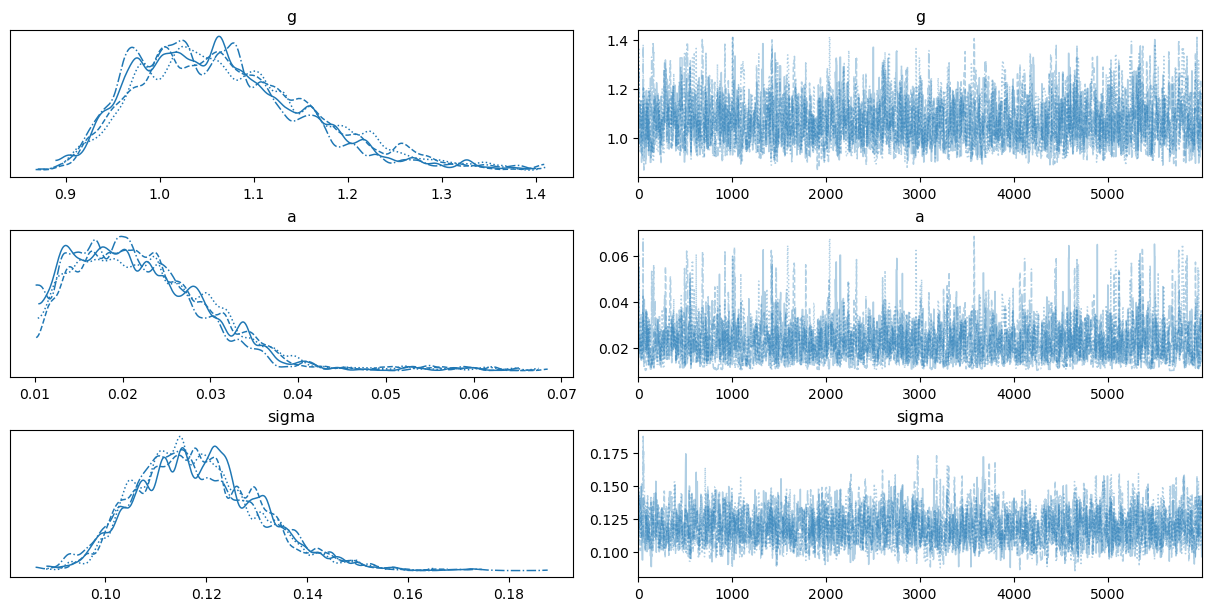

In [12]:
plt.rcParams['figure.constrained_layout.use'] = True
az.plot_trace(trace,combined=False);
az.summary(trace, var_names=["g","a"], round_to=3)


/Users/amanda/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


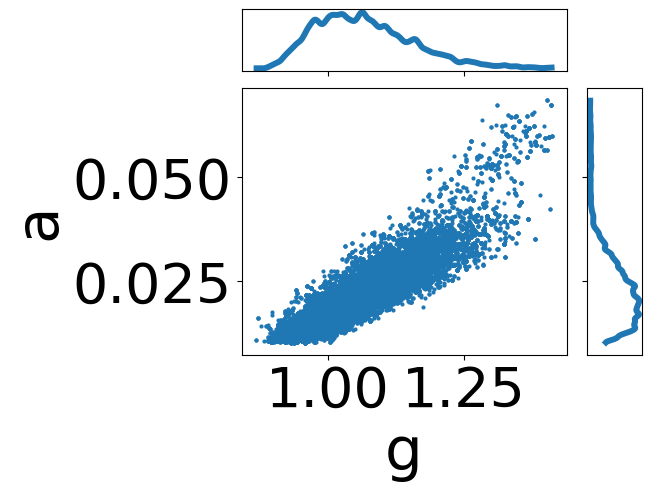

In [13]:
# Use Arviz to look at correlations

az.plot_pair(trace, var_names=['g','a'], marginals=True,textsize=40)
plt.savefig("/Users/amanda/Documents/Postdoc/Python_scripts/Auxotroph-ABC-posteriors/trace_plot_nonaut2-10-12-2024.pdf", format="pdf", dpi=300)
